# Session 12: Gaussian Mixture Models and the EM algorithm

------------------------------------------------------
*Introduction to Data Science & Machine Learning*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

[Mixture Models](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch20.pdf) are a special class of probabilistic generative models that can be used for both **density estimation** and **clustering**. Given a set of multidimensional observations, mixture models assume that observed variables are correlated because they arise from a hidden common "cause" or **latent variable** that is discrete (it can only take a finite number of values).

Fitting the parameters of Mixture Models is particularly challenging, as we deal with non-convex problems characterized by multiple modes. The **Expectation-Maximization (EM)** algorithm provides a simple iterative solution that guarantees to converge to a **local mode**.

In this notebook, we will present the EM algorithm to fit a Mixture of Gaussian distributions or [**Gaussian Mixture Models** (GMM)](https://brilliant.org/wiki/gaussian-mixture-model/).

Recommended bibliography:
- Chapter 09 of Pattern Recognition and Machine Learning, Christopher Bishop, 2006
- Chapter 11 of Machine Learning, a Probabilistic Perspective, Kevin Murply 2012

## Mixture Models

We say that a distribution $p(\mathbf{x})$ is a **mixture of $K$ component** distributions
$p_{1}(\mathbf{x}, p_{2}(\mathbf{x}),\ldots,p_{K}(\mathbf{x})$ if

\begin{align}
p(\mathbf{x})=\sum_{k=1}^{K} \pi_k p_{k}(\mathbf{x}),
\end{align}
with $\pi_k$ being the **mixing weights**, $\pi_k>0$, $\sum_k \pi_k =1$. An equivalent way to understad a Mixture Model is to think that every sample $\mathbf{x}$ is generated by first sample a discrete R.V. $z\in\{1,\ldots,K\}$ with probabilities $\pi_1,\ldots,\pi_K$, and then generate a sample $\mathbf{x}$ from $p_k(\mathbf{x})$. Namely,
\begin{align}
p(\mathbf{x})=\int_{z} p(\mathbf{x},z) dz = \sum_{k=1}^{K} \pi_k p_{k}(\mathbf{x}),
\end{align}
where 
\begin{align}
p(\mathbf{x},z) = \prod_{k=1}^{K} \left(\pi_k ~p_{k}(\mathbf{x})\right)^{\mathbb{1} [z==k]}
\end{align}

### Mixture of Gaussians

The most wiely used mixture model is the GMM. In this model, each component distribution in the mixture is a multivariate Gaussian with mean $\mathbf{\mu}_k$ and covariance matrix $\mathbf{\Sigma}_k$:
\begin{align}
p_{k}(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
\end{align}

Lets generate a toy dataset of samples coming from a GMM.

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Text(0,0.5,'y')

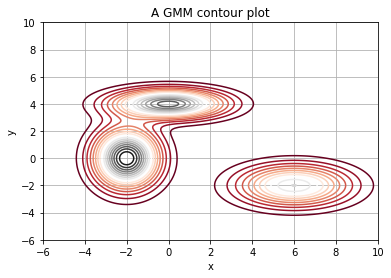

In [81]:
mus = np.array([[0,4], [-2,0], [6,-2]])
sigmas = np.array([   [[3, 0], [0, 0.5]], [[1,0],[0,2]], [[3,0],[0,1]] ])
pis = np.array([0.3, 0.4, 0.3])


# Lets plot the pdf contour plot
intervals = 200
x = np.linspace(-6, 12, intervals)
y = np.linspace(-6, 12, intervals)

X,Y = np.meshgrid(x,y)

xys = np.vstack([X.ravel(), Y.ravel()]).T

Z = np.zeros(len(xys))
for pi, mu, sigma in zip(pis, mus, sigmas):
    Z += pi*mvn(mu, sigma).pdf(xys)

Z = Z.reshape([intervals,intervals])
plt.contour(X, Y, Z, 20, cmap='RdGy')    
plt.grid()
plt.title('A GMM contour plot')
plt.xlabel('x')
plt.ylabel('y')

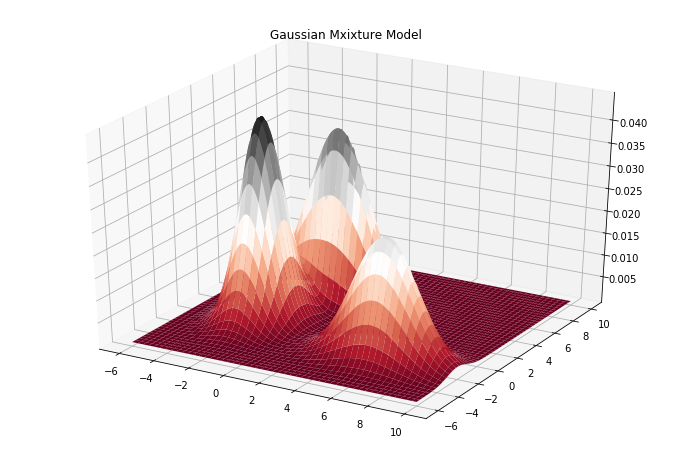

In [83]:
# And the pdf surfplace plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='RdGy')
plt.title('Gaussian Mxixture Model');

In [92]:
# Create a dataset of samples of the above GMM

N = 250

X_samples= np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*N))
                    for pi, mu, sigma in zip(pis, mus, sigmas)])

Text(0,0.5,'y')

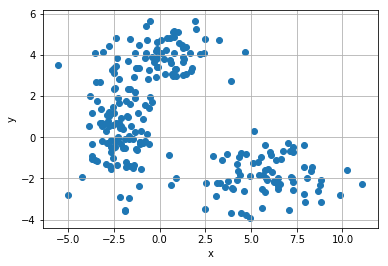

In [93]:
plt.scatter(X_samples[:,0],X_samples[:,1])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

## Learning a GMM from samples with the EM algorithm

Imagine we are given a dataset $\{\mathbf{x}^{(i)}\}$, $i=1,\ldots,N$, and we want to fit a GMM to explain this data set. For a given number $K$ of components, our goal is to find $\mathbf{\theta}\triangleq[\mathbf{\pi},\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K,\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K]$ to maximize the **log-likelihood of the observed data**:

\begin{align}
\ell(\mathbf{\theta})=\sum_{i=1}^{N} \log \left[\sum_{z^{(i)}} p(\mathbf{x}^{(i)},z^{(i)}|\mathbf{\theta}\right]
\end{align}

Unfortunately this is hard to optimize, since the log cannot be pushed inside the sum. The **Expectation Maximization (EM)** algorithm gets around this problem as follows. Define the **complete data log likelihood** to be

\begin{align}
\ell_c(\mathbf{\theta})=\sum_{i=1}^{N} \log  p(\mathbf{x}^{(i)},z^{(i)}|\mathbf{\theta})
\end{align}

$\ell_c(\mathbf{\theta})$ cannot be computed **since $z_i$ is unknown!**. Given our **current estimate** to $\mathbf{\theta}$, denoted by $\mathbf{\theta}_{t-1}$, we  define the **expected complete data log-likelihood** as follows:

\begin{align}
\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})=\int_{\mathbf{z}} \ell_c(\mathbf{\theta}) ~~  p(\mathbf{z}|\mathbf{X},\mathbf{\theta}_{t-1}) = \sum_{i=1}^{N} \mathbb{E}_{z^{(i)}\sim p(z^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})}\left[\log p(\mathbf{x}^{(i)},z^{(i)})\right]
\end{align}

Computing $\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})$ is referred as the **E-step** of the algorithm. In the **M-step**, we optimize the $\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})$ w.r.t. $\mathbf{\theta}$:

\begin{align}
\mathbf{\theta}^t = \arg\max_{\mathbf{\theta}} \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})
\end{align}

It can be proved that **the EM algorithm monotonically increases the log likelihood of the observed data** $\ell(\mathbf{\theta})$.

Lets visualize the [EM-implementation for GMMs provided by scitkit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture), then we will particularize the above equations.

Component Mean comparison
[[-2.1663303   0.17337805]
 [ 5.80578585 -1.90786012]
 [ 0.04121181  3.93878012]]
[[ 0  4]
 [-2  0]
 [ 6 -2]]


Component weight comparison
[ 0.39389427  0.30911283  0.29699291]
[ 0.3  0.4  0.3]


Train loglikelihood
-4.26495002926


Text(0,0.5,'y')

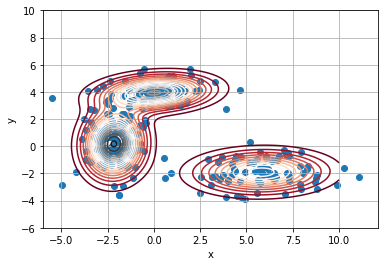

In [140]:
#Plots
from sklearn import mixture

K = 3

gmm = mixture.GaussianMixture(n_components=K,covariance_type='full')

gmm.fit(X_samples)

# True means vs Estimated means (they can be in a different order!)
print('Component Mean comparison')
print(gmm.means_)
print(mus)
print('\n')

# True weights vs Estimated weights (they can be in a different order!)
print('Component weight comparison')
print(gmm.weights_)
print(pis)
print('\n')

# Loglikelihood
print('Train loglikelihood')
print(np.mean(gmm.score_samples(X_samples)))


gmm_means = gmm.means_
gmm_covs = gmm.covariances_
gmm_pis = gmm.weights_


Zgmm = np.zeros(len(xys))
for pi, mu, sigma in zip(gmm_pis, gmm_means, gmm_covs):
    Zgmm += pi*mvn(mu, sigma).pdf(xys)

Zgmm = Zgmm.reshape([intervals,intervals])
plt.contour(X, Y, Zgmm, 20, cmap='RdGy') 
plt.scatter(X_samples[:,0],X_samples[:,1])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')



## EM update equations for the GMM

Now that we have seen how to use the EM algorithm, let's take a closer look to the GMM EM updates.

### E-step

The expected complete data log likelihood is given by 

\begin{align}
\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})&= \sum_{i=1}^{N} \mathbb{E}_{z^{(i)}\sim p(z^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})}\left[\log p(\mathbf{x}^{(i)},z^{(i)})\right]=\sum_{i=1}^{N} \mathbb{E}_{z^{(i)}\sim p(z^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})}\left[\log \prod_{k=1}^{K} \left(\pi_k ~ \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)\right)^{\mathbb{1} [z==k]} \right] \\\\
&= \sum_{i=1}^{N}\sum_{k=1}^K p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \left[\log \pi_k +\log \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)\right],
\end{align}
where, using Baye's rule,
\begin{align}
p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \triangleq r_{ik} = \frac{\pi_{(k,t-1)} \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_{(k,t-1)},\mathbf{\Sigma}_{(k,t-1)})}{\sum_{q=1}^K \pi_{(q,t-1)} \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_{(q,t-1)},\mathbf{\Sigma}_{(q,t-1)})}
\end{align}

$r_{ik}$ is known as the responsibility that cluster $k$ takes for data point $i$ (given $\mathbf{\theta}_{t-1}$)

### M-step

In the M step, we optimize $\mathcal{Q}$ w.r.t. $\pi_k,\mathbf{\mu}_k,\mathbf{\Sigma}_k$, $k=1,\ldots,K$.

#### Optimization of $\pi_k$

It is easy to see that
\begin{align}
\pi_k = \frac{1}{N} \sum_{i=1}^N r_{ik}=\frac{r_k}{N},
\end{align}
where $r_k=\sum_{i=1}^N r_{ik}$ is the weighted number of points assigned to cluster $k$.

#### Optimization of $\mathbf{\mu}_k$, $\mathbf{\Sigma}_k$

We look at the parts of $\mathcal{Q}$ that depend on $\mathbf{\mu}_k$ and $\mathbf{\Sigma}_k$
\begin{align}
f(\mathbf{\mu}_k,\mathbf{\Sigma}_k) = \frac{-1}{2}\sum_{i=1}^N r_{ik} \left[\log |\mathbf{\Sigma}_k| + (\mathbf{x}^{(i)}-\mathbf{\mu}_k)^T\mathbf{\Sigma}^{-1}_k(\mathbf{x}^{(i)}-\mathbf{\mu}_k)\right]
\end{align}

and one can show that the new parameter estimates are given by (See Section 9.2.2 of Bishop's Book for details)

\begin{align}
\mathbf{\mu}_k &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}}{r_k} \\ \\
\mathbf{\mu}_k &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}(\mathbf{x}^{(i)})^T}{r_k}-\mathbf{\mu}_k\mathbf{\mu}_k^T
\end{align}

Thus, the EM for Gaussian Mixture Models is **very easy to implement!**. 

## Model Comparison

An important question that typically arises when fitting a generative probabilistic model is how to select the right number of components. This problem is known as **model selection**.

A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, **using cross-validation to avoid over-fitting.** Namely, we evaluate the model log-likelihood for a validation set not used for training. 

Alternatively, the optimal Bayesian approach is to pick the model with the largest **marginal likelihood**:

\begin{align}
K^* = \arg\max_{K} p(\mathbf{X}|K) = \arg\max_{K} \int_{\mathbf{\theta}} p(\mathbf{X}|\mathbf{\theta},K) p(\mathbf{\theta}|K) d\mathbf{\theta}
\end{align}

In general, computing the marginal likelihood is quite difficult. Assuming a that prior distribution $p(\mathbf{\theta}|K)$ is Gaussian and very broad, we can approximate this term by the so-called **Bayessian Information Criterion** (BIC)
\begin{align}
-\log p(\mathbf{X}|K) \approx \frac{K\log N}{2}-p(\mathbf{X}|\mathbf{\theta}_{MAP},K)
\end{align}

where $\mathbf{\theta}_{MAP}$ is the mode of $p(\mathbf{\theta}|\mathbf{X},K)$, which is what we approximate with the EM (assuming again a very broad prior that does not weight much if the number of data points is large enough). **See Section 4.4.1. of Bishop's book for more details**.

Lets plot the BIC criterion for different values of $K$ in the above example

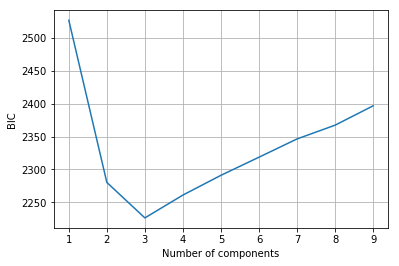

In [151]:
K_list = range(1,10)
BIC_list = [] 

for k in K_list:
    gmm = mixture.GaussianMixture(n_components=k,covariance_type='full').fit(X_samples)
    BIC_list.append(gmm.bic(X_samples))
    
plt.plot(K_list,BIC_list)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid()

Note that the minimum is attained at the right number of components

# GMM for a real dataset

Lets run the method for the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine). These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the **three types of wines**. 

The attributes are explained [here](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names)

In [160]:
from numpy import genfromtxt

wine_data = genfromtxt('wine.csv', delimiter=',')

print('Dataset size is',wine_data.shape)

#Lets normalize
mean = np.mean(wine_data)
var = np.var(wine_data)

wine_data -= mean
wine_data /= var


Dataset size is (6497, 13)


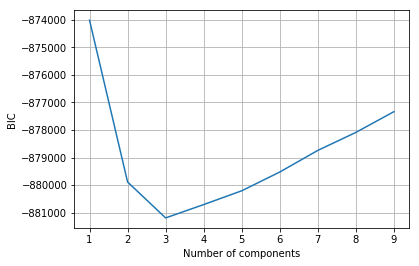

In [163]:
K_list = range(1,10)
BIC_list = [] 

for k in K_list:
    gmm = mixture.GaussianMixture(n_components=k,covariance_type='full').fit(wine_data)
    BIC_list.append(gmm.bic(wine_data))
    
plt.plot(K_list,BIC_list)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid()